In [1]:
# -*-coding:utf-8 -*-
# import all the libraries 
# python==3.8; jupyterlab==3.0.12; lumicks.pylake==0.8.1; matplotlib==3.3.4; more-itertools==8.7.0;
# npTDMS==1.1.0; numpy==1.20.1; opencv-python==4.5.1.48; pandas==1.2.3; scipy==1.6.1; tifffile==2021.3.5
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import scipy.optimize
%matplotlib widget

# Plot reference 
0. Fit the data point with a double exponential decay curve [https://stackoverflow.com/questions/30356619/how-to-fit-a-two-term-exponential-in-python ]
1. Setting a relative frequency in a matplotlib histogram [https://stackoverflow.com/questions/9767241/setting-a-relative-frequency-in-a-matplotlib-histogram]
2. Bin size in Matplotlib (Histogram) [https://stackoverflow.com/questions/6986986/bin-size-in-matplotlib-histogram]
3. logscale axis [https://stackoverflow.com/questions/773814/plot-logarithmic-axes-with-matplotlib-in-python]
4. binwidth for histogram Using the The Freedman-Diaconis Rules to calculate the binwidth: The bin-width is set to h=2×IQR×n^(−1/3),the number of bins is (max−min)/h; where IQR is the interquartile range of the data and n is the number of observations in the sample [https://stats.stackexchange.com/questions/798/calculating-optimal-number-of-bins-in-a-histogram]
5. Alternatively, The simplest method is to set the number of bins equal to the square root of the number of values you are binning.
6. Generate random numbers from exponential distribution [https://stackoverflow.com/questions/47319277/generate-random-numbers-from-exponential-distribution-and-model-using-python]
7. error band plot [https://stackoverflow.com/questions/55368485/draw-error-shading-bands-on-line-plot-python?noredirect=1&lq=1]

In [48]:
# read and plot the trajectory analysis data from Kymotracker
# trace_name = input('please type in the file name:' ) + '.xlsx'
# trace_path = input('please type in the file path:')
# trace_file = os.path.join(trace_path, trace_name) 
trace_file = r'E:\OneDrive - Vrije Universiteit Amsterdam\T7 gp2.5 MS_2021\Data&CodeRepository\Fig4\wtSSB\12pN\sequence_section analysis_1Apr2022\Duration_AT_GC.xlsx' 

In [68]:
trace = pd.read_excel(trace_file,sheet_name='GC')
print(trace.head())
duration_observed = trace['dt_ms']/1000

# bleaching correction
bleaching_time = 13.23
# bleaching_time = 92.85
duration = abs((bleaching_time*duration_observed)/(bleaching_time - duration_observed))

data = duration.dropna()
print(data)

   dt_ms
0   3590
1    718
2    718
3    718
4   7906
0        4.926940
1        0.759202
2        0.759202
3        0.759202
4       19.646202
          ...    
5998     0.756967
5999     0.756967
6000     0.758084
6001     0.758084
6002     0.759202
Name: dt_ms, Length: 6003, dtype: float64


In [69]:
a = round(np.min(data),2)
print(a)

0.76


In [71]:
#calculate interquartile range and subsequent binwidth, and then histogram
# q3, q1 = np.percentile(data, [75 ,25])
# iqr = q3 - q1
# binwidth = (2* iqr) * len(data) ** (-1/3)
# print(binwidth)
binwidth = round(np.min(data),2)
binwidth = 0.8

ydata,base = np.histogram(data,bins = np.arange(min(data), max(data)+ binwidth, binwidth), weights=np.zeros_like(data) + 1. / data.size)
xdata = base[:-1] + 0.5*binwidth

plt.figure()
plt.scatter(xdata, ydata, color="k")
plt.yscale('log')
plt.ylim(0.001,1)
plt.xlim(0,18)
plt.ylabel('Probability Density Function')
plt.xlabel('Duration (s)')
plt.title('Mapping of the distribution of data')
plt.show()
# plt.savefig(trace_file[:-18]+ 'Mapping of the distribution of data' +'.png', dpi=300)
# plt.savefig(trace_file[:-5]+ '_Mapping of the distribution of data' +'.png', dpi=300)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [72]:
# this step is to fit the data in a specific range
xdata1 = xdata[np.where(xdata<100)]
ydata1 = ydata[np.where(xdata<100)]

In [73]:
# fit the data with a monoExponential decay curve
def TripleExp(x, a1,k1,a2,k2,a3,k3):
    return a1 * np.exp(-k1 * x) + a2 * np.exp(-k2 * x)+ a3 * np.exp(-k3 * x)

# perform the fit
# Here you give the initial parameters for a,b,c which Python then iterates over to find the best fit

# popt, pcov = scipy.optimize.curve_fit(TripleExp, xdata1, ydata1,maxfev=50000)
# popt, pcov = scipy.optimize.curve_fit(TripleExp, xdata1, ydata1,p0=(100,5,5,0.1,0.1,0.1),maxfev=50000)

# #for AT
popt, pcov = scipy.optimize.curve_fit(TripleExp, xdata1, ydata1,bounds=((10, 1, 0.1, 0.1,0.001,0.05), (50, 10, 1, 1,0.05,0.08)),maxfev=50000)

# for GC
# popt, pcov = scipy.optimize.curve_fit(TripleExp, xdata1, ydata1,bounds=((10, 1, 0.1, 0.1,0.001,0.01), (50, 10, 2, 1.5,0.05,0.2)),maxfev=50000)

# a1 & a2 is the initial value A1 & A2, k1 & k2 is the decay constant
a1, k1, a2,k2,a3,k3 = popt
perr = np.sqrt(np.diag(pcov))
print(perr)

# determine quality of the fit
squaredDiffs = np.square(ydata1 - TripleExp(xdata1, a1, k1,a2,k2,a3,k3))
squaredDiffsFromMean = np.square(ydata1 - np.mean(ydata1))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")

# # plot extroplating fitted curve
# xdata2 = np.arange(0,10,0.1)
# ydata2 = monoExp(xdata2, a, k)/a

# plot the results
plt.figure()
plt.scatter(xdata1, ydata1, color="k", label="data")
plt.plot(xdata1, TripleExp(xdata1, a1, k1,a2,k2,a3,k3), '--', label="fitted")
# plt.plot(xdata2, monoExp(xdata2, a, k)/a, 'yellow', label="normarlized")

plt.text(1.5,0.5,'y =' + str(a1) + ' * exp^('+ str(-k1)+'x)')
plt.text(2,0.3,'+' +str(a2) + ' * exp^('+ str(-k2)+'x)')
plt.text(2,0.2,'+' +str(a3) + ' * exp^('+ str(-k3)+'x)')
plt.text(2,0.1,'R² = ' + str(rSquared))
plt.text(2.5,0.05,'Error = ' + str(perr[:2]))
plt.text(5,0.03,'= ' + str(perr[2:4]))
plt.text(5,0.02,' = ' + str(perr[4:6]))

plt.yscale('log')
plt.ylim(0.0001,1)
plt.xlim(0,40)
plt.legend(loc = 'lower left')
plt.ylabel('Probability Density Function')
plt.xlabel('Time(s)')
plt.title("Duration Analysis of GC-rich Region")
plt.show()
plt.tight_layout()

[5.76537263e+01 1.32858284e+00 3.26391067e-01 1.20725113e-01
 3.19353168e-03 4.28522723e-02]
R² = 0.9987185157928563


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [101]:
pasuse

NameError: name 'pasuse' is not defined

In [74]:
# random sampling
resampling_ratio = 0.7
resampling_times = 1000

# fit the data with a TriExponential decay curve
def TripleExp(x, a1,k1,a2,k2,a3,k3):
    return a1 * np.exp(-k1 * x) + a2 * np.exp(-k2 * x)+ a3 * np.exp(-k3 * x)

# define a function to compute the decay constant from an exponential decay fit, with return of decay constant
def ExoDecFit (data):
    #calculate interquartile range and subsequent binwidth, and then histogram
#     binwidth = round(np.min(data),2)
    binwidth = 0.8
    ydata,base = np.histogram(data,bins = np.arange(min(data), max(data)+ binwidth, binwidth), weights=np.zeros_like(data) + 1. / data.size)
    xdata = base[:-1] + 0.5*binwidth
    
    xdata1 = xdata[np.where(xdata<100)]
    ydata1 = ydata[np.where(xdata<100)]

    # perform the fit
    # Here you give the initial parameters for a,b,c which Python then iterates over to find the best fit
    try:
    # perform the fit
    # Here you give the range of parameters for a,b,c which Python then iterates over to find the best fit
        # popt, pcov = scipy.optimize.curve_fit(TripleExp, xdata1, ydata1,bounds=((10, 1, 0.1, 0.1,0.0001,0.01), (50, 10, 1, 1.5,0.05,0.5)),maxfev=50000)
        
        # for AT/GC analysis
        popt, pcov = scipy.optimize.curve_fit(TripleExp, xdata1, ydata1,bounds=((10, 1, 0.1, 0.1,0.001,0.01), (50, 10, 1, 1.5,0.002,0.08)),maxfev=50000)
    except RuntimeError:
        pass
    
    # determine quality of the fit
    squaredDiffs = np.square(ydata1 - TripleExp(xdata1, a1, k1,a2,k2,a3,k3))
    squaredDiffsFromMean = np.square(ydata1 - np.mean(ydata1))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    
    return popt
    # if rSquared >= 0.999:
    #     # if popt is not None:
    #     if popt == []:
    #         return popt

fit_res_ls = []
for i in range (resampling_times):
    # random sampling with replacement method,
    data_resampling = np.random.choice(data, size= int(resampling_ratio * len(data)), replace=True)
    fit_res = ExoDecFit(data_resampling)
    fit_res_ls.append(fit_res)
        # return format(np.mean(decay_constant_ls),'.4f'),format (np.std(decay_constant_ls),'.4f')
        
print(len(fit_res_ls))
# print(np.mean(decay_constant_ls))
# print(np.std(decay_constant_ls))

1000


In [75]:
# compute all the parameters
a1_mean = np.mean(np.array(fit_res_ls)[:,0])
a1_std = np.std(np.array(fit_res_ls)[:,0])
k1_mean = np.mean(np.array(fit_res_ls)[:,1])
k1_std = np.std(np.array(fit_res_ls)[:,1])

a2_mean = np.mean(np.array(fit_res_ls)[:,2])
a2_std = np.std(np.array(fit_res_ls)[:,2])
k2_mean = np.mean(np.array(fit_res_ls)[:,3])
k2_std = np.std(np.array(fit_res_ls)[:,3])

a3_mean = np.mean(np.array(fit_res_ls)[:,4])
a3_std = np.std(np.array(fit_res_ls)[:,4])
k3_mean = np.mean(np.array(fit_res_ls)[:,5])
k3_std = np.std(np.array(fit_res_ls)[:,5])

# save the processing data
result = [a1_mean,a1_std,k1_mean,k1_std,a2_mean,a2_std,k2_mean,k2_std,a3_mean,a3_std,k3_mean,k3_std]
all_population = np.array([np.array(fit_res_ls)[:,0],np.array(fit_res_ls)[:,1],np.array(fit_res_ls)[:,2],np.array(fit_res_ls)[:,3],np.array(fit_res_ls)[:,4],np.array(fit_res_ls)[:,5]]).T
# print(result)
np.savetxt(trace_file[:-19]+ '_koff fit from GC_bleachCorrected' + '.txt', result, delimiter=',')
np.savetxt(trace_file[:-19]+ 'all population from GC-bleachCorrected' + '.txt', all_population, delimiter=',')

In [76]:
# plot the results
plt.figure(figsize = (8,6))
plt.scatter(xdata1, ydata1, color="k", label="data")
plt.plot(xdata1, TripleExp(xdata1, a1, k1,a2,k2,a3,k3), '--', label="TriExp fitted")
# plt.plot(xdata2, monoExp(xdata2, a, k)/a, 'yellow', label="normarlized")

plt.text(1.5,0.5,'y =' + str(a1_mean) + ' * exp^('+ str(-k1_mean)+'x)')
plt.text(2,0.3,'+' +str(a2_mean) + ' * exp^('+ str(-k2_mean)+'x)')
plt.text(2,0.2,'+' +str(a3_mean) + ' * exp^('+ str(-k3_mean)+'x)')

plt.text(5,0.09,'Error = ' + str([a1_std,k1_std]))
plt.text(5,0.07,'Error = ' + str([a2_std,k2_std]))
plt.text(5,0.05,'Error = ' + str([a3_std,k3_std]))

plt.text(5,0.02,'bootstrap results:'+ '('+ str(resampling_ratio*100) + ' % of the raw data ' + 'for' + str(resampling_times) + ' times )')
plt.text(5,0.01,'N = ' + str(len(data)))

plt.yscale('log')
plt.ylim(0.0001,1)
plt.xlim(0,40)
plt.legend(loc = 'lower left')
plt.ylabel('Probability Density Function')
plt.xlabel('Time(s)')
plt.title("Duration Analysis of GC")
plt.show()
plt.tight_layout()
plt.savefig(trace_file[:-19]+ '_koff fit from GC' +'.png', dpi=300)
plt.savefig(trace_file[:-19]+ '_koff fit from GC' +'.eps', format = 'eps')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [ ]:
pause

In [67]:
xdata_at = xdata1
ydata_at = ydata1
ydata_at_fit = TripleExp(xdata1, a1, k1,a2,k2,a3,k3)

In [77]:
xdata_gc = xdata1
ydata_gc = ydata1
ydata_gc_fit = TripleExp(xdata1, a1, k1,a2,k2,a3,k3)

In [78]:
# plot the results
plt.figure(figsize = (4,3))
plt.scatter(xdata_at, ydata_at, color="chocolate")
plt.plot(xdata_at, ydata_at_fit, '--', color="chocolate",label="AT-region")

plt.scatter(xdata_gc, ydata_gc, color="mediumblue")
plt.plot(xdata_gc, ydata_gc_fit, '--', color="mediumblue",label="GC-region")

plt.yscale('log')
plt.ylim(0.0001,1.5)
plt.xlim(0,30)
plt.legend(loc = 'upper right')
plt.ylabel('Probability Density Function')
plt.xlabel('Time(s)')
# plt.title("Duration Analysis")
plt.show()
plt.tight_layout()
# plt.savefig('Fig 4D' + '.png', dpi = 300)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
pause

In [145]:
# read the sequence data along DNA
# name example: 20200304-160513 10pN- 30nM DNAp + 0.1mg_mL_BSA #019-002
cor_name = input('please type in the file name:' ) + '.xlsx'
# path example: C:\Users\12345\Desktop
cor_path = input('please type in the file path:')
cor_filename = os.path.join(cor_path, cor_name) 

please type in the file name: all population_koff
please type in the file path: D:\Google Drive\T7 gp2.5 MS_2021\Data&CodeRepository\Fig4\wtSSB\12pN\sequence_section analysis_1Apr2022


          a1        a2        a3  a2/(a1+a2+a3)  a1/(a1+a2+a3)     type
0  10.168086  0.100000  0.001755       0.009737       0.990092  GC-Rich
1  10.116473  0.282813  0.001402       0.027192       0.972673  GC-Rich
2  12.352783  0.195167  0.002276       0.015551       0.984268  GC-Rich
3  11.518327  0.223386  0.001838       0.019022       0.980822  GC-Rich
4  10.000000  0.172649  0.002223       0.016968       0.982813  GC-Rich


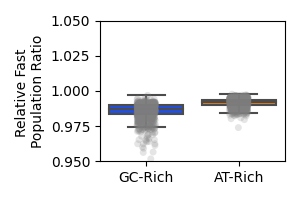

In [181]:
import seaborn as sns
data_cor = pd.read_excel(cor_filename, sheet_name = "a2_(a1+a2+a3)")
print(data_cor.head())

fig, ax = plt.subplots(figsize = (3,2))
# make grouped boxplot and save it in a variable
sns.boxplot(x="type", y="a1/(a1+a2+a3)", data=data_cor,showfliers = False)
sns.set_palette("bright",20)

# make grouped stripplot and save it in a variable
sns.stripplot(x="type", y="a1/(a1+a2+a3)", data=data_cor,jitter=True,dodge=True, alpha=0.2,color='grey')

ax.set_ylabel("Relative Fast \nPopulation Ratio")
ax.set_ylim(0.95,1.05)
ax.set_xlabel("")
# ax.set_ylim(0.95,1.05)
plt.tight_layout()
plt.show()
plt.savefig('Fig 4D Inset1' +'.png', dpi=300)

In [ ]:
pause

In [ ]:
# fit the data with a fixed value
def TripleExp(x, a2,k2,a3,k3):
    return 47.5 * np.exp(-4.8 * x) + a2 * np.exp(-k2 * x)+ a3 * np.exp(-k3 * x)

# perform the fit
# Here you give the initial parameters for a,b,c which Python then iterates over to find the best fit

popt, pcov = scipy.optimize.curve_fit(TripleExp, xdata1, ydata1,p0=(0.15,.66,0.004,0.1),maxfev=50000)
# a1 & a2 is the initial value A1 & A2, k1 & k2 is the decay constant
a2,k2,a3,k3 = popt

# determine quality of the fit
squaredDiffs = np.square(ydata1 - TripleExp(xdata1, a2,k2,a3,k3))
squaredDiffsFromMean = np.square(ydata1 - np.mean(ydata1))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")

# # plot extroplating fitted curve
# xdata2 = np.arange(0,10,0.1)
# ydata2 = monoExp(xdata2, a, k)/a

# plot the results
plt.figure()
plt.scatter(xdata1, ydata1, color="k", label="data")
plt.plot(xdata1, TripleExp(xdata1, a2,k2,a3,k3), '--', label="fitted")
# plt.plot(xdata2, monoExp(xdata2, a, k)/a, 'yellow', label="normarlized")

plt.text(1.5,0.5,'y =' + str(47.5) + ' * exp^('+ str(-4.8)+'x)')
plt.text(2,0.3,'+' +str(a2) + ' * exp^('+ str(-k2)+'x)')
plt.text(2,0.2,'+' +str(a3) + ' * exp^('+ str(-k3)+'x)')
plt.text(1.5,0.1,'R² = ' + str(rSquared))
plt.text(2.5,0.05,'Error = ' + str(perr[:2]))
plt.text(5,0.03,'= ' + str(perr[2:4]))
plt.text(5,0.02,' = ' + str(perr[4:6]))

plt.yscale('log')
plt.ylim(0.0001,1)
plt.xlim(0,20)
plt.legend(loc = 'lower left')
plt.ylabel('Probability Density Function')
plt.xlabel('Time(s)')
plt.title("Duration Analysis")
plt.show()

In [ ]:
pasue

# Form now on, we start to bootstrap the data

In [ ]:
# random sampling
resampling_ratio = 0.8
resampling_times = 10000

# fit the data with a monoExponential decay curve
def TripleExp(x, a1, k1,a2,k2):
    return a1 * np.exp(-k1 * x) + a2 * np.exp(-k2 * x)

# define a function to compute the decay constant from an exponential decay fit, with return of decay constant
def ExoDecFit (data):
    #calculate interquartile range and subsequent binwidth, and then histogram
    # q3, q1 = np.percentile(data, [75 ,25])
    # iqr = q3 - q1
    # binwidth = (2* iqr) * len(data) ** (-1/3)
    binwidth = 0.4
    ydata,base = np.histogram(data,bins = np.arange(min(data), max(data)+ binwidth, binwidth), weights=np.zeros_like(data) + 1. / data.size)
    xdata = base[:-1] + 0.5*binwidth
    xdata1 = xdata[np.where(xdata<18)]
    ydata1 = ydata[np.where(xdata<18)]

    # perform the fit
    # Here you give the initial parameters for a,b,c which Python then iterates over to find the best fit
    try:
        popt, pcov = scipy.optimize.curve_fit(TripleExp, xdata1, ydata1,p0=(1.0,1.0,1.0,1.0))
    except RuntimeError:
        pass
    # a1 & a2 is the initial value A1 & A2, k1 & k2 is the decay constant
    # a1, k1, a2, k2 = popt
    return popt

fit_res_ls = []
for i in range (resampling_times):
    # random sampling with replacement method,
    data_resampling = np.random.choice(data, size= int(resampling_ratio * len(data)), replace=True)
    fit_res = ExoDecFit(data_resampling)
    fit_res_ls.append(fit_res)

        # return format(np.mean(decay_constant_ls),'.4f'),format (np.std(decay_constant_ls),'.4f')
    
print(len(fit_res_ls))
# print(np.mean(decay_constant_ls))
# print(np.std(decay_constant_ls))

In [ ]:
pasue

In [ ]:
# plot the results
plt.figure()
plt.scatter(xdata1, ydata1, color="k", label="data")
plt.plot(xdata1, monoExp(xdata1, a, k), '--', label="fitted")
plt.plot(xdata2, monoExp(xdata2, a, k)/a, 'yellow', label="normarlized")

plt.text(1.5,0.7,'y =' + str(a) + ' * exp^('+ str(-k)+'x)')
plt.text(1.5,0.5,'R² = ' + str(rSquared))
plt.text(1.5,0.3,'bootstrap results:'+ '('+ str(resampling_ratio*100) + ' % of the raw data ' + 'for' + str(resampling_times) + ' times )')
plt.text(1.5,0.2,'N = ' + str(len(data)))
plt.text(1.5,0.15,'koff = ' + str(np.mean(decay_constant_ls)) + '±' +  str(np.std(decay_constant_ls)))

plt.yscale('log')
plt.ylim(0.001,1)
plt.xlim(0,8)
plt.legend(loc = 'lower right')
plt.ylabel('Probability Density Function')
plt.xlabel('Time(s)')
plt.title("Duration Analysis")
plt.show()
# plt.savefig(trace_file[:-18]+ 'duration-analysis' +'.png', dpi=300)
# plt.savefig(trace_file[:-5]+ '_duration-analysis' +'.png', dpi=300)

In [ ]:
pause
# we will not use the following codes

In [ ]:
duration = mydata
time_bin = xdata2
frequency_fit = monoExp(xdata2, a, k)
frequency_fit_norm = monoExp(xdata2, a, k)/a
fit_data =  np.vstack((time_bin,frequency_fit,frequency_fit_norm)).T
exp_output = np.array([duration,fit_data],dtype=object)
print(exp_output)
np.save(trace_file[:-4]+ '_duration-analysis' + '.npy', exp_output, allow_pickle=True)

In [ ]:
pause
exp_output = np.load(trace_file[:-4]+ '_duration-analysis' + '.npy', allow_pickle=True)
frequency_fit_norm = exp_output[1][:,2]

In [ ]:
# read and plot the trajectory analysis data from Kymotracker
name = input('please type in the file name:' ) 
path = input('please type in the file path:')
file = os.path.join(path, name) 
exp_output_2 = np.load(file, allow_pickle=True)

In [ ]:
time = np.arange(0,15,0.5)
frequency_fit_norm_1 = exp_output_1[1][:,2]
frequency_fit_norm_2 = exp_output_2[1][:,2]
# frequency_fit_norm_3 = exp_output_3[1][:,2]
# frequency_fit_norm_4 = exp_output_4[1][:,2]
# frequency_fit_norm_5 = exp_output_5[1][:,2]
# frequency_fit_norm_6 = exp_output_6[1][:,2]
# frequency_fit_norm_7 = exp_output_7[1][:,2]


plt.figure()
plt.scatter(time,frequency_fit_norm_1,color = 'r')
plt.plot(time,frequency_fit_norm_1,'--')
plt.scatter(time,frequency_fit_norm_2,color = 'blue')
plt.plot(time,frequency_fit_norm_2,'--')
# plt.scatter(time,frequency_fit_norm_3,color = 'green')
# plt.plot(time,frequency_fit_norm_3,'--')
# plt.scatter(time,frequency_fit_norm_4,color = 'green')
# plt.plot(time,frequency_fit_norm_4,'--')
# plt.scatter(time,frequency_fit_norm_5,color = 'green')
# plt.plot(time,frequency_fit_norm_5,'--')
# plt.scatter(time,frequency_fit_norm_6,color = 'green')
# plt.plot(time,frequency_fit_norm_6,'--')
# plt.scatter(time,frequency_fit_norm_7,color = 'green')
# plt.plot(time,frequency_fit_norm_7,'--')
# plt.plot(time,(frequency_fit_norm_1+frequency_fit_norm_2+frequency_fit_norm_3+frequency_fit_norm_4+frequency_fit_norm_5+frequency_fit_norm_6+frequency_fit_norm_7)/7,linewidth = 3,color = "black",label ="average")

plt.xlabel('Time(s)')
plt.ylabel("Frequency")
plt.yscale('log')
plt.ylim(0.01,1)
plt.xlim(0,15)
plt.title("Duration Analysis")
plt.legend()

plt.show()
# fig.savefig('_duration-analysis' +'.png', dpi=150)